In [1]:
# Install Ultralytics library
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall

In [2]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
from ultralytics import YOLO
from IPython.display import Video
import csv
import albumentations as A

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

In [4]:
# Load a pretrained YOLOv8n model from Ultralytics
model = YOLO('yolov8m.pt')

In [ ]:
# Path to the image file
image_path = '/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000016.png'

# Perform inference on the provided image(s)
results = model.predict(source=image_path, 
                        imgsz=640,  # Resize image to 640x640 (the size pf images the model was trained on)
                        conf=0.5)   # Confidence threshold: 50% (only detections above 50% confidence will be considered)

# Annotate and convert image to numpy array
sample_image = results[0].plot(line_width=2)

# Convert the color of the image from BGR to RGB for correct color representation in matplotlib
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Display annotated image
plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Pre-trained YOLOv8s Model on Kitti Dataset', fontsize=20)
plt.axis('off')
plt.show()


image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000016.png: 224x640 9 cars, 1 truck, 1 traffic light, 54.8ms
Speed: 10.0ms preprocess, 54.8ms inference, 274.5ms postprocess per image at shape (1, 3, 224, 640)


In [6]:
# Root directory of the KITTI dataset
kitti_base_path = "/kaggle/input/kitti-dataset"

# Training images and labels
kitti_images_dir = os.path.join(kitti_base_path, "data_object_image_2/training/image_2")
kitti_labels_dir = os.path.join(kitti_base_path, "data_object_label_2/training/label_2")

# YOLO dataset directories
yolo_dataset_path = "YOLOv8_dataset"
yolo_images_train = os.path.join(yolo_dataset_path, "images/train")
yolo_images_val = os.path.join(yolo_dataset_path, "images/val")
yolo_labels_train = os.path.join(yolo_dataset_path, "labels/train")
yolo_labels_val = os.path.join(yolo_dataset_path, "labels/val")

# Create directories
os.makedirs(yolo_images_train, exist_ok=True)
os.makedirs(yolo_images_val, exist_ok=True)
os.makedirs(yolo_labels_train, exist_ok=True)
os.makedirs(yolo_labels_val, exist_ok=True)

print("Directories set up correctly.")

Directories set up correctly.


In [7]:
# KITTI class labels
kitti_classes = ["Car", "Pedestrian", "Cyclist", "Truck", "Van"]

# Augmentation pipeline (apply only for training images)
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(p=0.2),
    A.RandomGamma(p=0.3),
    A.Affine(scale=(0.9, 1.1), translate_percent=0.05, rotate=(-10, 10), p=0.5),
    A.CLAHE(p=0.2),
    A.OneOf([
        A.HueSaturationValue(p=0.3),
        A.RGBShift(p=0.3)
    ], p=0.4),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

def convert_kitti_to_yolo(label_file, split="train"):
    with open(os.path.join(kitti_labels_dir, label_file), "r") as f:
        lines = f.readlines()

    new_lines = []
    bboxes = []
    class_labels = []

    for line in lines:
        parts = line.strip().split()
        obj_class = parts[0]
        if obj_class in kitti_classes:
            x_min, y_min, x_max, y_max = map(float, parts[4:8])
            width = 1242  # Adjust if your image size differs
            height = 375

            x_center = ((x_min + x_max) / 2) / width
            y_center = ((y_min + y_max) / 2) / height
            bbox_width = (x_max - x_min) / width
            bbox_height = (y_max - y_min) / height

            yolo_class = kitti_classes.index(obj_class)
            new_lines.append(f"{yolo_class} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            bboxes.append([x_center, y_center, bbox_width, bbox_height])
            class_labels.append(yolo_class)

    return new_lines, bboxes, class_labels

def save_yolo_format(label_lines, label_path):
    with open(label_path, "w") as f:
        f.writelines(label_lines)

def augment_and_save(img_path, label_lines, bboxes, class_labels, split_dir, base_name, count=3):
    image = cv2.imread(img_path)
    height, width = image.shape[:2]

    for i in range(count):
        try:
            aug = augment(image=image, bboxes=bboxes, class_labels=class_labels)
            aug_img = aug["image"]
            aug_bboxes = aug["bboxes"]
            aug_labels = aug["class_labels"]

            if not aug_bboxes:
                continue  # skip if no bbox remains

            # Save augmented image
            aug_img_name = f"aug_{i}_{base_name}"
            cv2.imwrite(os.path.join(split_dir["images"], aug_img_name), aug_img)

            # Save augmented label
            with open(os.path.join(split_dir["labels"], aug_img_name.replace(".png", ".txt")), "w") as f:
                for bbox, cls in zip(aug_bboxes, aug_labels):
                    f.write(f"{cls} {' '.join(map(str, bbox))}\n")
        except Exception as e:
            print(f"Error augmenting {base_name}: {e}")

# Split dataset (80% train, 20% val)
image_files = sorted(os.listdir(kitti_images_dir))
split_idx = int(0.8 * len(image_files))

train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

for file in tqdm(train_files, desc="Processing Training Data"):
    base_name = file.replace(".png", ".txt")
    label_lines, bboxes, class_labels = convert_kitti_to_yolo(base_name, "train")

    # Save original image and label
    shutil.copy(os.path.join(kitti_images_dir, file), os.path.join(yolo_images_train, file))
    save_yolo_format(label_lines, os.path.join(yolo_labels_train, base_name))

    # Apply and save augmentations
    augment_and_save(
        os.path.join(kitti_images_dir, file),
        label_lines,
        bboxes,
        class_labels,
        {"images": yolo_images_train, "labels": yolo_labels_train},
        file,
        count=1  # Number of augmentations per image
    )

for file in tqdm(val_files, desc="Processing Validation Data"):
    base_name = file.replace(".png", ".txt")
    label_lines, _, _ = convert_kitti_to_yolo(base_name, "val")
    shutil.copy(os.path.join(kitti_images_dir, file), os.path.join(yolo_images_val, file))
    save_yolo_format(label_lines, os.path.join(yolo_labels_val, base_name))

print("KITTI annotations converted, dataset split, and augmentation completed.")

Processing Validation Data: 100%|██████████| 1497/1497 [00:25<00:00, 59.15it/s]

KITTI annotations converted, dataset split, and augmentation completed.


In [8]:
dataset_yaml = f"""\
path: /kaggle/working/YOLOv8_dataset
train: images/train
val: images/val
names:
  0: Car
  1: Pedestrian
  2: Cyclist
  3: Truck
  4: Van
"""

with open("/kaggle/working/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("Updated dataset.yaml file created ✅")

Updated dataset.yaml file created ✅


In [9]:
# Define the dataset_path
dataset_path = '/kaggle/working/'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'dataset.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
  0: Car
  1: Pedestrian
  2: Cyclist
  3: Truck
  4: Van
path: /kaggle/working/YOLOv8_dataset
train: images/train
val: images/val



In [10]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'YOLOv8_dataset', 'images', 'train')
valid_images_path = os.path.join(dataset_path, 'YOLOv8_dataset', 'images', 'val')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.png'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.png'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 11968
Number of validation images: 1497
Training images have varying sizes.
Validation images have varying sizes.


In [11]:
import torch
print(torch.cuda.is_available())  # Phải trả về True nếu GPU đã bật
print(torch.cuda.device_count())  # Số GPU có được

True
1


In [ ]:
# # Train the model on our custom dataset
# results = model.train(
#     data=yaml_file_path,     # Path to the dataset configuration file
#     epochs=100,              # Number of epochs to train for
#     imgsz=640,               # Size of input images as integer
#     device=0,                # Device to run on, i.e. cuda device=0 
#     patience=20,             # Epochs to wait for no observable improvement for early stopping of training
#     batch=32,                # Number of images per batch
#     optimizer='auto',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
#     lr0=0.001,              # Initial learning rate 
#     lrf=0.1,                 # Final learning rate (lr0 * lrf)
#     seed=0                   # Random seed for reproducibility
# )

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("einsamerwolf/yolov8s-results-on-kitti")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/yolov8s-results-on-kitti


In [13]:
# Define the path to the directory
# post_training_files_path = '/kaggle/working/runs/detect/train'
post_training_files_path = '/kaggle/input/yolov8s-results-on-kitti/runs/detect/train'

# List the files in the directory
!ls {post_training_files_path}

args.yaml			 labels.jpg	       train_batch33662.jpg
BoxF1_curve.png			 results.csv	       val_batch0_labels.jpg
BoxP_curve.png			 results.png	       val_batch0_pred.jpg
BoxPR_curve.png			 train_batch0.jpg      val_batch1_labels.jpg
BoxR_curve.png			 train_batch1.jpg      val_batch1_pred.jpg
confusion_matrix_normalized.png  train_batch2.jpg      val_batch2_labels.jpg
confusion_matrix.png		 train_batch33660.jpg  val_batch2_pred.jpg
labels_correlogram.jpg		 train_batch33661.jpg  weights


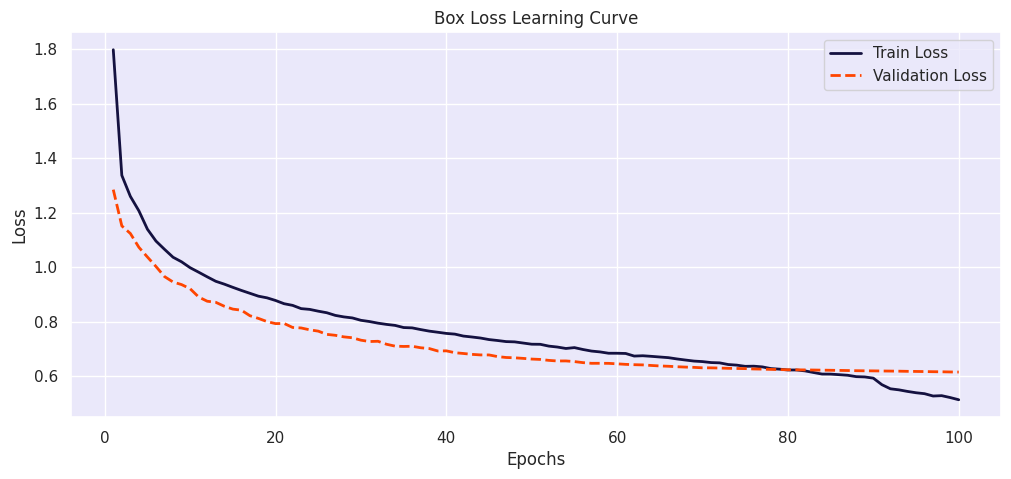

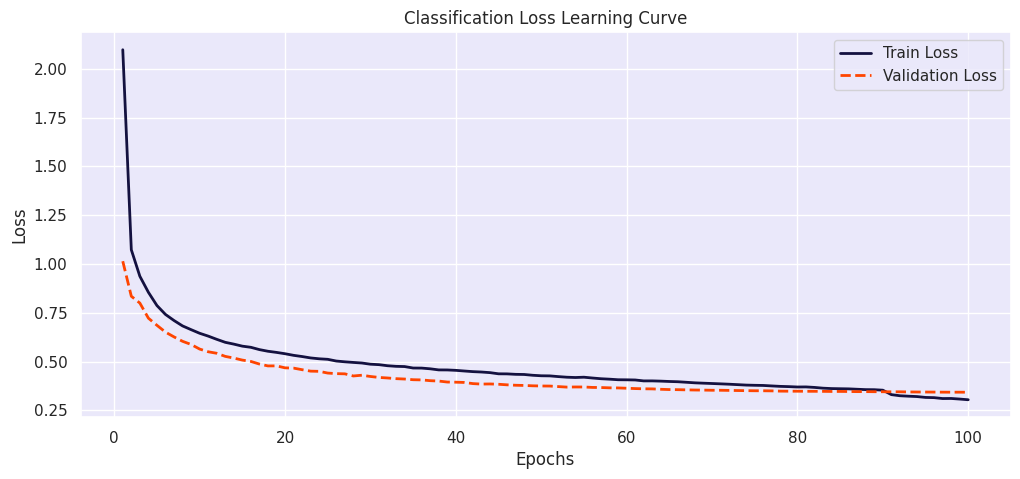

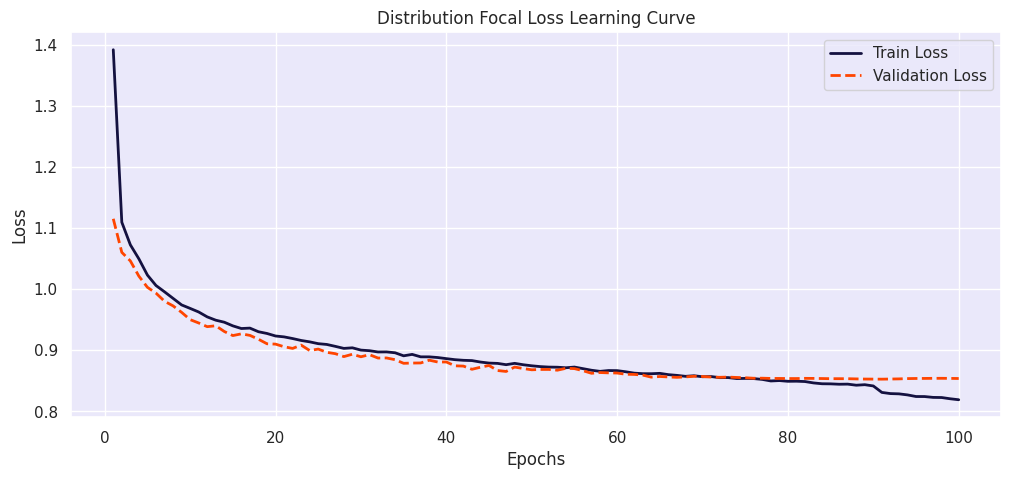

In [14]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# Create the full file path for 'results.csv' using the directory path and file name
results_csv_path = os.path.join(post_training_files_path, 'results.csv')

# Load the CSV file from the constructed path into a pandas DataFrame
df = pd.read_csv(results_csv_path)

# Remove any leading whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')

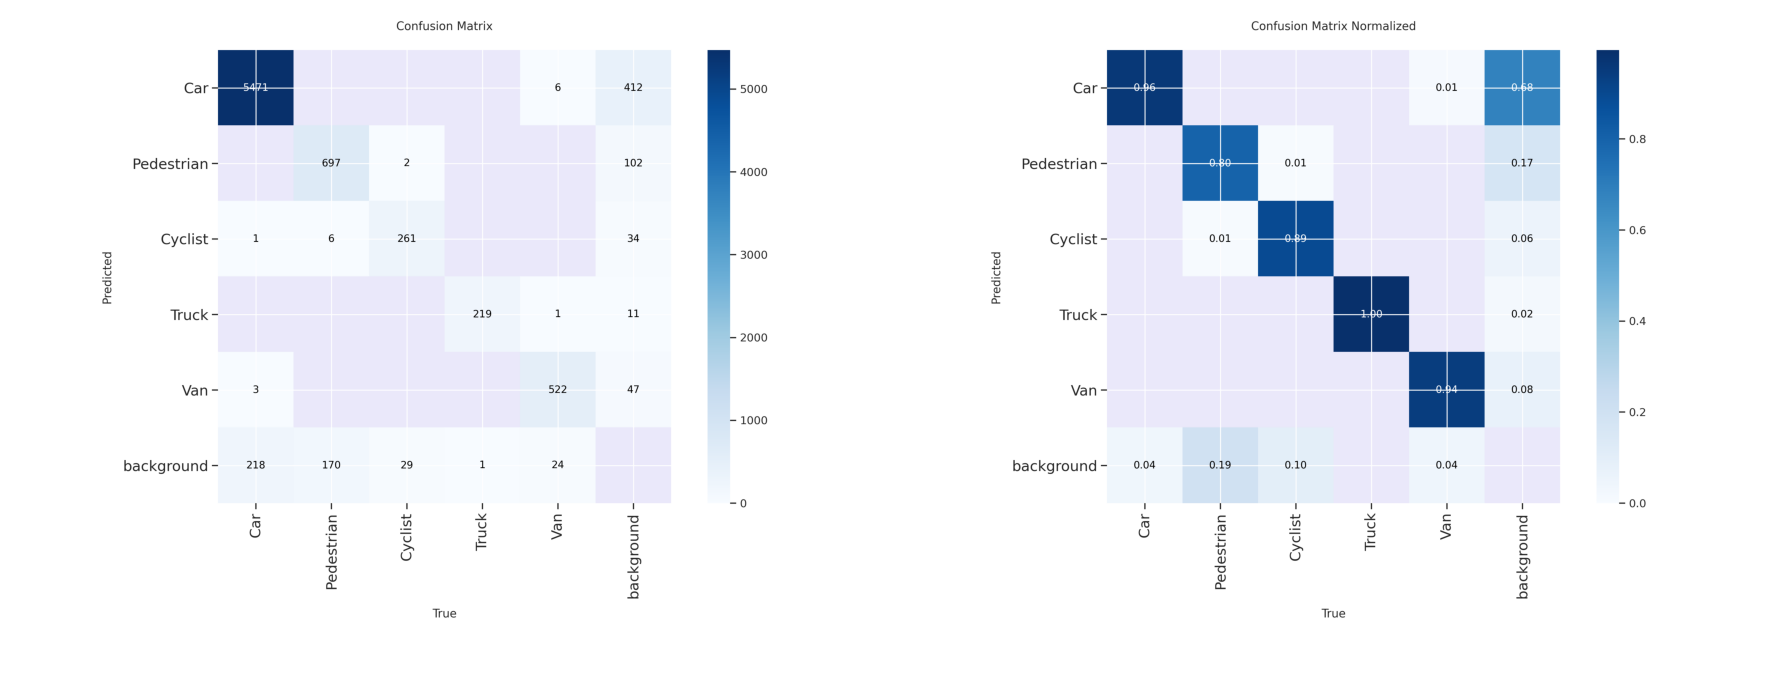

In [15]:
# Construct the path to the normalized confusion matrix image
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix.png')
confusion_matrix_normalized_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# Read the image using cv2
cm_img = cv2.imread(confusion_matrix_path)
cm_img_normalized = cv2.imread(confusion_matrix_normalized_path)

# Convert the image from BGR to RGB color space for accurate color representation with matplotlib
cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)
cm_img_normalized = cv2.cvtColor(cm_img_normalized, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(15, 10), dpi=120)

plt.subplot(1, 2, 1)
plt.imshow(cm_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cm_img_normalized)
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val', device=0)

Ultralytics 8.3.172 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4347.7±1057.6 MB/s, size: 859.5 KB)



val: Scanning /kaggle/working/YOLOv8_dataset/labels/val... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:07<00:00, 200.58it/s]

val: New cache created: /kaggle/working/YOLOv8_dataset/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


                   all       1497       7631      0.939      0.904      0.948      0.769
                   Car       1338       5693      0.947      0.949      0.981      0.864
            Pedestrian        349        873      0.917      0.756      0.865      0.537
               Cyclist        209        292      0.928      0.884      0.929      0.697
                 Truck        208        220      0.961      0.991       0.99      0.904
                   Van        421        553      0.942      0.942      0.974      0.843
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val



image 1/1 /kaggle/working/YOLOv8_dataset/images/val/006660.png: 224x640 9 Cars, 3 Vans, 33.4ms
Speed: 1.3ms preprocess, 33.4ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/working/YOLOv8_dataset/images/val/007198.png: 224x640 3 Cars, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/working/YOLOv8_dataset/images/val/006515.png: 224x640 4 Cars, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/working/YOLOv8_dataset/images/val/006876.png: 224x640 2 Cars, 1 Truck, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/working/YOLOv8_dataset/images/val/007088.png: 224x640 4 Cars, 1 Van, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/working/YOLOv8_dataset/images/val/006589

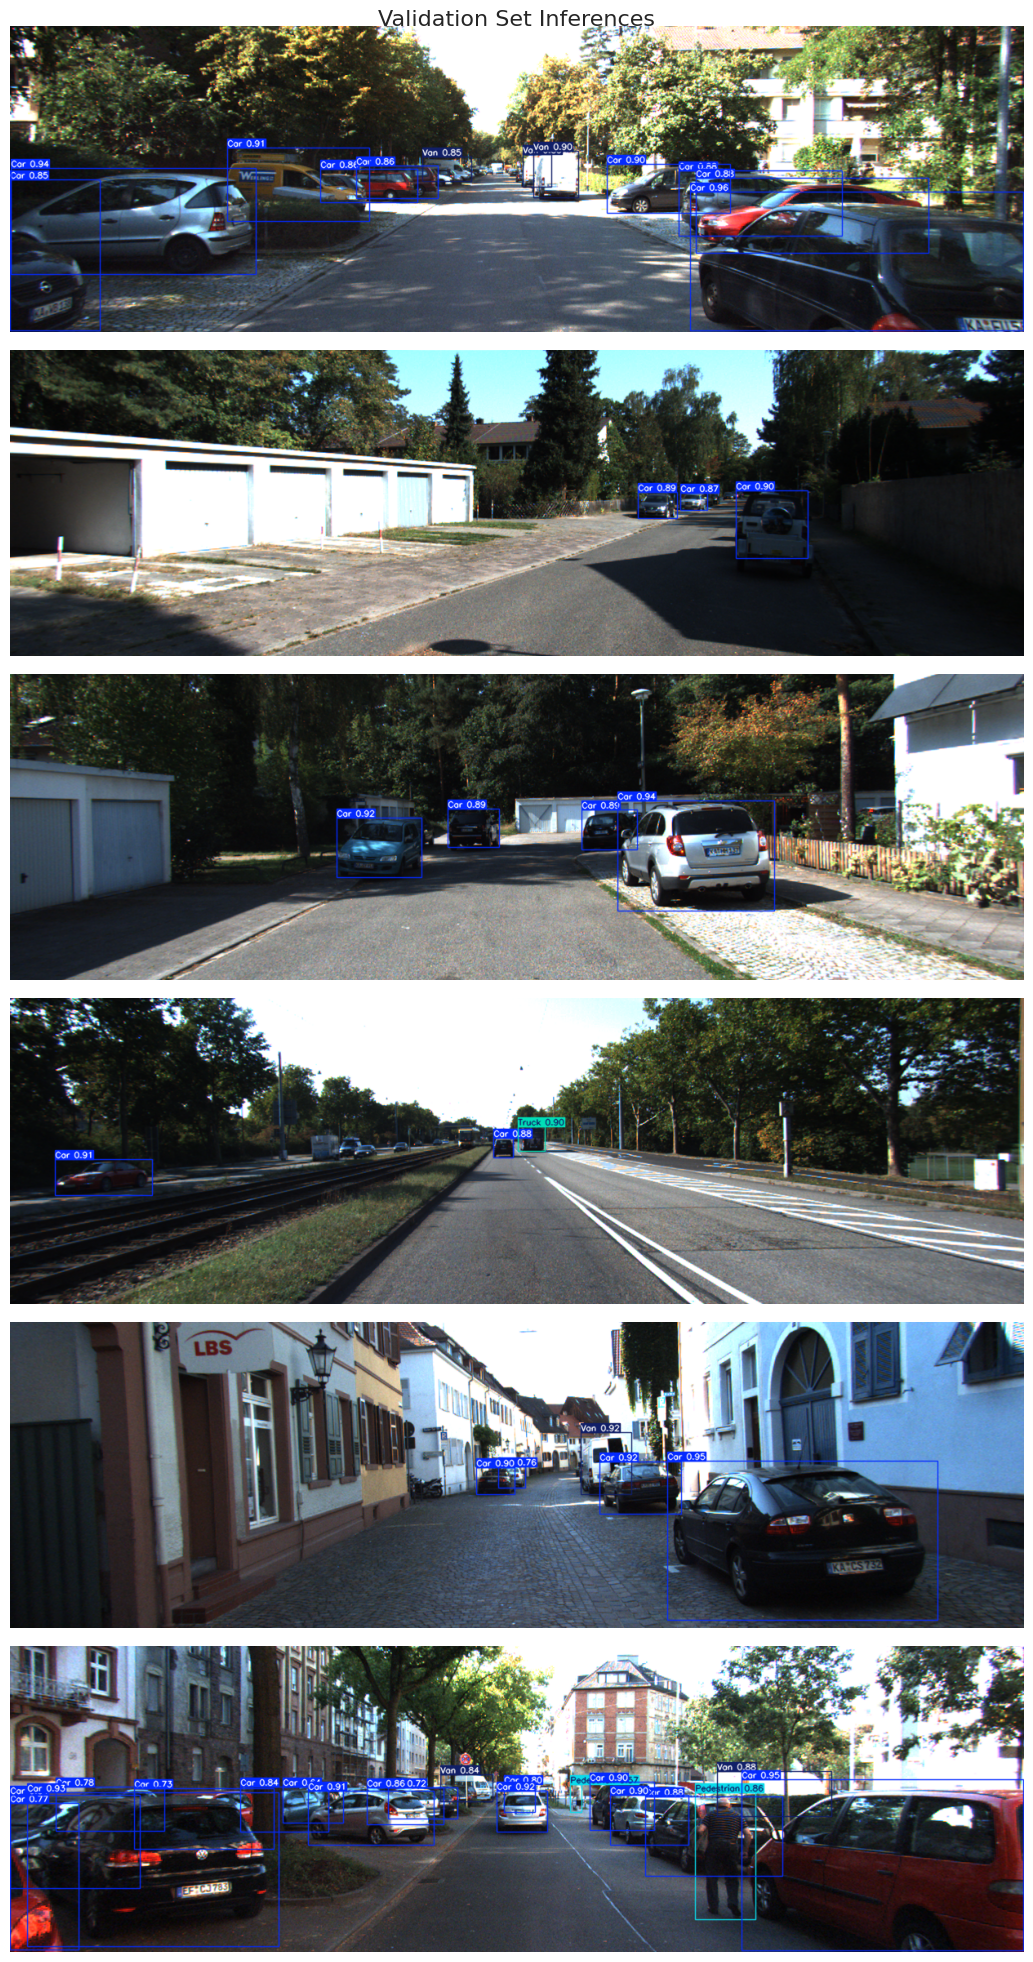

In [17]:
# Define the path to the validation images
valid_images_path = os.path.join(dataset_path,'YOLOv8_dataset', 'images', 'val')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.png')]

# Select 6 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 6)]

# Initialize the subplot
fig, axes = plt.subplots(6, 1, figsize=(25, 20))
fig.suptitle('Validation Set Inferences', fontsize=16)

# Perform inference on each selected image and display it
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(valid_images_path, selected_images[i])
    results = best_model.predict(source=image_path, imgsz=640, conf=0.5)
    annotated_image = results[0].plot(line_width=1)
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    ax.imshow(annotated_image_rgb)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# Display the DataFrame
metrics_df.round(3)

Metric Value
metrics/precision(B)         0.939
metrics/recall(B)            0.904
metrics/mAP50(B)             0.948
metrics/mAP50-95(B)          0.769
fitness                      0.787


image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000016.png: 224x640 4 Cars, 1 Truck, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)


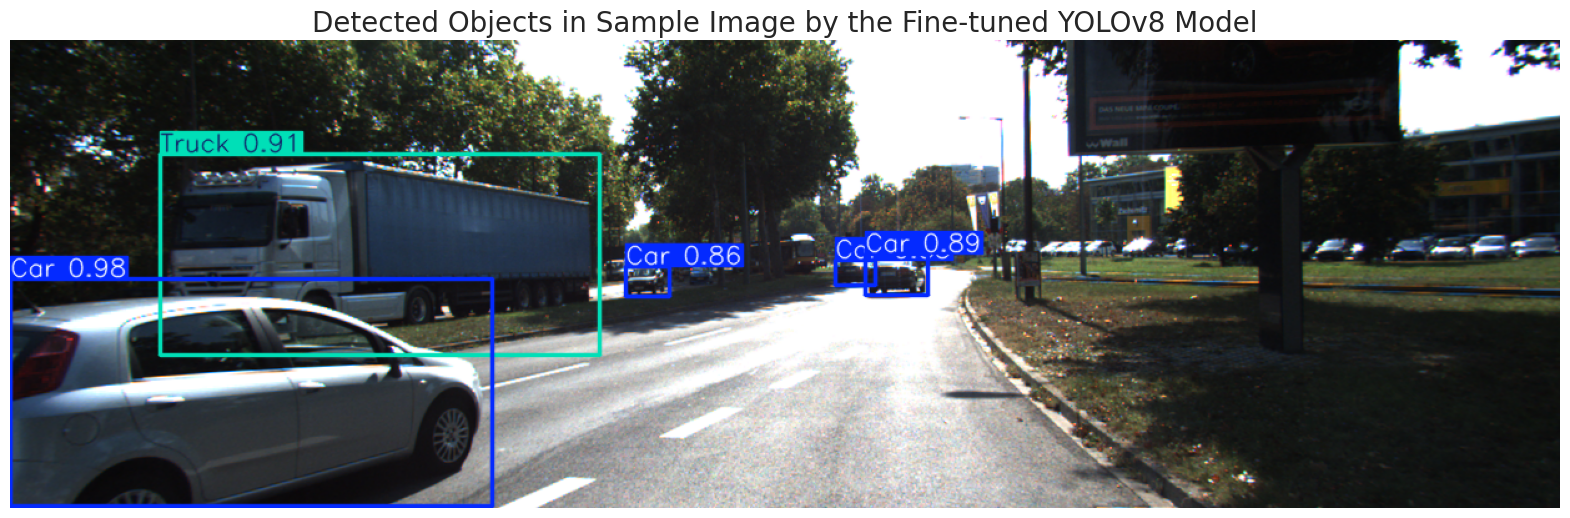

In [19]:
# Path to the image file
sample_image_path = '/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000016.png'

# Perform inference on the provided image using best model
results = best_model.predict(source=sample_image_path, imgsz=640, conf=0.7) 
                        
# Annotate and convert image to numpy array
sample_image = results[0].plot(line_width=2)

# Convert the color of the image from BGR to RGB for correct color representation in matplotlib
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Display annotated image
plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Fine-tuned YOLOv8 Model', fontsize=20)
plt.axis('off')
plt.show()

In [20]:
# Define the path to the sample video in the dataset
dataset_video_path = '/kaggle/input/vid-test1/vehicle-counting.mp4'

# Define the destination path in the working directory
video_path = '/kaggle/working/sample_video.mp4'

# Copy the video file from its original location in the dataset to the current working directory in Kaggle for further processing
shutil.copyfile(dataset_video_path, video_path)

'/kaggle/working/sample_video.mp4'

In [21]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 1.4 MB/s eta 0:00:0000:010:010m


In [22]:
def apply_clahe_brightness(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

In [23]:
pip install ultralytics opencv-python labelme numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 53.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 21.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 67.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 44.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [32]:
import cv2
import numpy as np
from collections import defaultdict, deque
from supervision import ByteTrack, Detections

# ==== Load video ====
video_path = '/kaggle/input/vid-test1/vehicle-counting.mp4'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    raise ValueError("Không đọc được frame!")

height, width = frame.shape[:2]
fps = cap.get(cv2.CAP_PROP_FPS)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# ==== Video Writer ====
out = cv2.VideoWriter("/kaggle/working/output_lane_count.mp4",
                      cv2.VideoWriter_fourcc(*"mp4v"),
                      fps,
                      (width, height))

# ==== Load YOLOv8 model ====
best_model.to('cuda')

# ==== Polygon vùng đếm ====
left_polygon = np.array([(1000, 900), (1700, 900), (2000, 1700), (200, 1700)], dtype=np.int32)
right_polygon = np.array([(2000, 900), (2700, 900), (3700, 1700), (2200, 1700)], dtype=np.int32)

# ==== Tracker và bộ đếm ====
tracker = ByteTrack()
track_memory = {}
lane_record = {}  # track_id: 'left' / 'right'
count_left = 0
count_right = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Vẽ polygon
    cv2.polylines(frame, [left_polygon], isClosed=True, color=(255, 200, 0), thickness=3)
    cv2.polylines(frame, [right_polygon], isClosed=True, color=(0, 255, 255), thickness=3)

    # Phát hiện và tracking
    results = best_model(frame, verbose=False, conf=0.5)[0]
    detections = Detections.from_ultralytics(results)
    tracks = tracker.update_with_detections(detections)

    current_ids = set()
    current_left_count = 0
    current_right_count = 0

    for i in range(len(tracks)):
        x1, y1, x2, y2 = map(int, tracks.xyxy[i])
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        track_id = int(tracks.tracker_id[i])
        class_id = int(tracks.class_id[i])
        confidence = float(tracks.confidence[i])

        if class_id != 0 or confidence < 0.3:
            continue

        current_ids.add(track_id)

        # Ghi lại quỹ đạo
        if track_id not in track_memory:
            track_memory[track_id] = deque(maxlen=30)
        track_memory[track_id].append((cx, cy))

        # Kiểm tra vùng polygon
        in_left = cv2.pointPolygonTest(left_polygon, (cx, cy), False) >= 0
        in_right = cv2.pointPolygonTest(right_polygon, (cx, cy), False) >= 0

        # Cập nhật đếm nếu track mới đi vào làn nào
        if track_id not in lane_record:
            if in_left:
                lane_record[track_id] = 'left'
                count_left += 1
            elif in_right:
                lane_record[track_id] = 'right'
                count_right += 1

        # Đếm số xe hiện tại đang trong vùng polygon
        if in_left:
            current_left_count += 1
        elif in_right:
            current_right_count += 1

        # Xác định nhãn direction
        lane = lane_record.get(track_id, None)
        direction = "OUT"
        if lane == 'left' and in_left:
            direction = "IN"
        elif lane == 'right' and in_right:
            direction = "IN"

        label = f"ID {track_id} - {lane.upper() if lane else 'UNKNOWN'} - {direction}"

        # Hiển thị box và nhãn
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 200, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        cv2.circle(frame, (cx, cy), 4, (0, 255, 255), -1)

        # Vẽ quỹ đạo
        trail = track_memory[track_id]
        for j in range(1, len(trail)):
            pt1, pt2 = trail[j - 1], trail[j]
            cv2.line(frame, pt1, pt2, (0, 180, 255), 2)

    # Giữ lại các track còn tồn tại
    track_memory = {tid: trail for tid, trail in track_memory.items() if tid in current_ids}

    # Hiển thị tổng đếm và số xe đang có mặt
    cv2.putText(frame, f"Left Lane Total: {count_left} | Current: {current_left_count}", (60, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 128, 255), 2)
    cv2.putText(frame, f"Right Lane Total: {count_right} | Current: {current_right_count}", (60, 130),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

    out.write(frame)

# ==== Kết thúc ====
cap.release()
out.release()


In [ ]:
!ffmpeg -y -i /kaggle/working/output_lane_count.mp4 -vcodec libx264 -acodec aac /kaggle/working/output.mp4

In [ ]:
Video("/kaggle/working/output.mp4", embed=True, width=960)